In [2]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, RepeatVector
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [3]:
#Read KLSI stock price history file (From Wall Street Journal)
data = pd.read_csv('HistoricalPrices.csv')
data.head()

,Date,Open,High,Low,Close
0,01/02/1990,567.14,567.14,567.14,567.14
1,01/03/1990,582.68,582.68,582.68,582.68
2,01/04/1990,586.06,586.06,586.06,586.06
3,01/05/1990,582.58,582.58,582.58,582.58
4,01/08/1990,583.47,583.47,583.47,583.47


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7666 entries, 0 to 7665
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    7666 non-null   object 
 1    Open   7666 non-null   float64
 2    High   7666 non-null   float64
 3    Low    7666 non-null   float64
 4    Close  7666 non-null   float64
dtypes: float64(4), object(1)
memory usage: 299.6+ KB


In [5]:
#Convert date column to date type
data['Date'] = pd.to_datetime(data['Date'])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7666 entries, 0 to 7665
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7666 non-null   datetime64[ns]
 1    Open   7666 non-null   float64       
 2    High   7666 non-null   float64       
 3    Low    7666 non-null   float64       
 4    Close  7666 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 299.6 KB


In [7]:
data.shape
#Set the Date column as index of the pandas df
data = data.set_index('Date')

In [8]:
close_data = data[[' Close']]

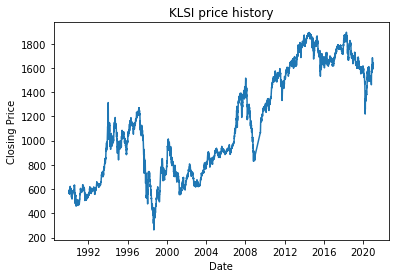

In [9]:
#Visualise the price history
plt.plot(close_data)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('KLSI price history')
plt.show()

In [10]:
#Split the first 80% dates into training data, remaining 20% into test
train_size = int(data.shape[0]*0.8)
train = close_data.iloc[:train_size]
test = close_data.iloc[train_size:]

In [11]:
#Scale the data for deep learning
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)


In [12]:
#Use previous 14 days to predict the closing price on a given day
X_train = []
Y_train = []

for i in range(len(train_scaled)-14):
    X_train.append(train_scaled[i:(i+14), 0])
    Y_train.append(train_scaled[i+14, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

In [13]:
print(X_train.shape)

(6118, 14)


In [14]:
#Reshape into a dimension suitable for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [15]:
#X_train for first day, and Y_train for first day
print("X_train/Prices up to 14 days before ith day")
print(X_train[0])
print("Y_train/Prices on ith day")
print(Y_train[0])

X_train/Prices up to 14 days before ith day
[[0.18677874]
 [0.19631277]
 [0.19838645]
 [0.19625142]
 [0.19679745]
 [0.19669315]
 [0.19947238]
 [0.2025829 ]
 [0.19953373]
 [0.18820209]
 [0.18690144]
 [0.19118378]
 [0.19104267]
 [0.19142918]]
Y_train/Prices on ith day
0.18983404398907944


In [86]:
#LSTM, use a dropout unit to avoid overfitting
model = Sequential()
model.add(LSTM(units = 32, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 16, activation = 'relu'))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 14, 32)            4352      
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________


In [87]:
history = model.fit(X_train, Y_train, epochs = 60, batch_size = 32, validation_split = 0.15,shuffle = False)


Epoch 1/60
163/163 [==============================] - 5s 14ms/step - loss: 0.0085 - val_loss: 0.0041
Epoch 2/60
163/163 [==============================] - 2s 10ms/step - loss: 0.0078 - val_loss: 8.3436e-04
Epoch 3/60
163/163 [==============================] - 2s 11ms/step - loss: 0.0074 - val_loss: 0.0011
Epoch 4/60
163/163 [==============================] - 2s 11ms/step - loss: 0.0051 - val_loss: 7.7266e-04
Epoch 5/60
163/163 [==============================] - 3s 16ms/step - loss: 0.0018 - val_loss: 7.9491e-04
Epoch 6/60
163/163 [==============================] - 2s 13ms/step - loss: 9.0718e-04 - val_loss: 0.0020
Epoch 7/60
163/163 [==============================] - 2s 13ms/step - loss: 9.7956e-04 - val_loss: 0.0019
Epoch 8/60
163/163 [==============================] - 2s 12ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 9/60
163/163 [==============================] - 2s 10ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 10/60
163/163 [==============================] - 2s 13ms/step - l

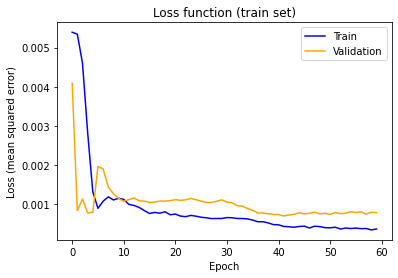

In [90]:
plt.plot(history.history['loss'], color = 'blue', label = 'Train')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (mean squared error)')
plt.title('Loss function (train set)')
plt.legend()
plt.show()

In [91]:
#Concat train and test and split again because the first 13 rows of the
#test set need to use rows from the train set
#Then transform again and create the 14 features for each test set row
whole_data = pd.concat((train, test), axis = 0)
inputs = whole_data[len(whole_data) - len(test) - 14:].values
inputs = inputs.reshape(-1,1) #1544, 1
inputs = scaler.transform(inputs)

X_test = []
Y_test = []

for i in range(len(inputs)-14):
    X_test.append(inputs[i:(i+14), 0])
    Y_test.append(inputs[i+14, 0])

X_test, Y_test = np.array(X_test), np.array(Y_test)
#X_test.shape = (1534,14)
#Y_test.shape = (1534,)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#X_test.shape = (1534,14,1)

In [92]:
#Use the trained model and test set to predict closing price
#Then inverse-transform the scaled prediction
Y_pred = model.predict(X_test)
Y_pred = scaler.inverse_transform(Y_pred)
Y_test = test[[' Close']]

In [93]:
#Create a data frame from the result for easier plotting with plt
Y_pred_df = pd.DataFrame(index = Y_test.index)
Y_pred_df['Close'] = Y_pred

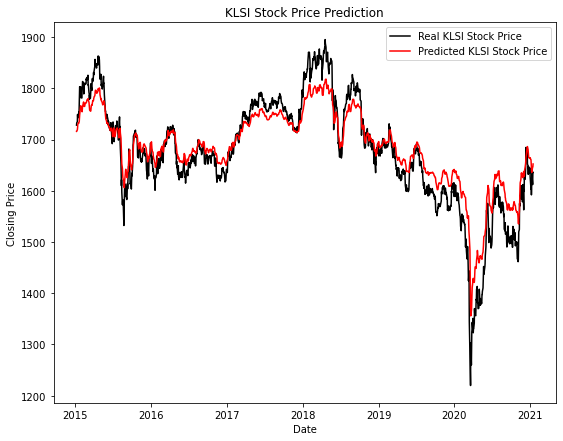

In [112]:
#Plot to compare real and predicted closing price
plt.figure(figsize = (9,7))
plt.plot(Y_test, color = 'black', label = 'Real KLSI Stock Price')
plt.plot(Y_pred_df, color = 'red', label = 'Predicted KLSI Stock Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('KLSI Stock Price Prediction')
plt.legend()
plt.show()

The trends of the closing price can be predicted quite accurately by the LSTM model.

In [95]:
#Calculate mean squared error of the model on test set
mse = np.sum(np.square(np.array(Y_test[[' Close']])- 
                        np.array(Y_pred_df[['Close']]))/(Y_pred_df.shape[0]))

print('Mean squared error of the prediction of the model:')
print(mse)

Mean squared error of the prediction of the model:
1356.0323783323527


**LSTM Autoencoder for anomaly detection**

In [24]:
#Built an LSTM autoencoder model to return predictions from the hidden layers
autoencoder = keras.Sequential()
autoencoder.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])
                    ))
autoencoder.add(Dropout(rate=0.2))
autoencoder.add(RepeatVector(n=X_train.shape[1]))
autoencoder.add(LSTM(units=64, return_sequences=True))
autoencoder.add(Dropout(rate=0.2))
autoencoder.add(TimeDistributed(Dense(X_train.shape[2])))
autoencoder.compile(optimizer='adam',loss='mean_squared_error')

In [25]:
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 14, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 14, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 64)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 14, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
__________________________________________________

In [26]:
autoencoder_history = model.fit(X_train, Y_train, epochs = 50,
                               batch_size=32, validation_split=0.15,
                               shuffle=False)

Epoch 1/50
163/163 [==============================] - 2s 11ms/step - loss: 3.4172e-04 - val_loss: 0.0015
Epoch 2/50
163/163 [==============================] - 1s 9ms/step - loss: 2.9993e-04 - val_loss: 0.0015
Epoch 3/50
163/163 [==============================] - 2s 9ms/step - loss: 3.4222e-04 - val_loss: 0.0015
Epoch 4/50
163/163 [==============================] - 2s 11ms/step - loss: 3.3374e-04 - val_loss: 0.0015
Epoch 5/50
163/163 [==============================] - 2s 10ms/step - loss: 3.1202e-04 - val_loss: 0.0014
Epoch 6/50
163/163 [==============================] - 2s 10ms/step - loss: 3.0366e-04 - val_loss: 0.0013
Epoch 7/50
163/163 [==============================] - 1s 9ms/step - loss: 3.0887e-04 - val_loss: 0.0013
Epoch 8/50
163/163 [==============================] - 1s 9ms/step - loss: 2.6697e-04 - val_loss: 0.0014
Epoch 9/50
163/163 [==============================] - 1s 9ms/step - loss: 2.9319e-04 - val_loss: 0.0014
Epoch 10/50
163/163 [==============================] - 2s 9m

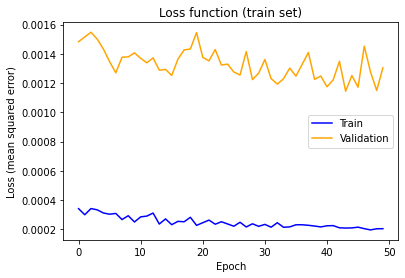

In [105]:
#Learning curve
plt.plot(autoencoder_history.history['loss'], color = 'blue', label = 'Train')
plt.plot(autoencoder_history.history['val_loss'], color = 'orange', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (mean squared error)')
plt.title('Loss function (train set)')
plt.legend()
plt.show()

In [31]:
#Predict the 14-day historical price (predict itself) using train set
train_pred = autoencoder.predict(X_train)


In [38]:
train_loss = np.mean(np.abs(train_pred - X_train),axis=1)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of mean absolute loss')

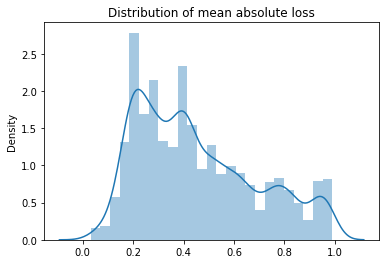

In [107]:
#Distribution of mean absolute loss function
sns.distplot(train_loss)
plt.title('Distribution of mean absolute loss')

In [101]:
#Predict using test set. Create a dataframe that represents which
#rows of prediction (which rows of test set) are anomalous
CUTOFF = 0.95 #we set 0.95 as a threshold (any day where MAE loss>0.95)
test_pred = autoencoder.predict(X_test)
test_loss = np.mean(np.abs(test_pred - X_test),axis=1)
autoencoder_df = pd.DataFrame(index = Y_test.index)
autoencoder_df['Loss'] = test_loss
autoencoder_df['Cutoff'] = CUTOFF
autoencoder_df['Anomaly'] = autoencoder_df.Loss > autoencoder_df.Cutoff
autoencoder_df['Close'] = Y_test[[' Close']]
autoencoder_df

,Loss,Cutoff,Anomaly,Close
Date,,,,
2015-01-08,0.897118,0.95,False,1728.06
2015-01-09,0.899165,0.95,False,1732.44
2015-01-12,0.900607,0.95,False,1735.08
2015-01-13,0.901458,0.95,False,1748.90
2015-01-14,0.901706,0.95,False,1742.01
...,...,...,...,...
2021-01-08,0.832999,0.95,False,1633.19
2021-01-11,0.831261,0.95,False,1617.25
2021-01-12,0.829716,0.95,False,1612.04


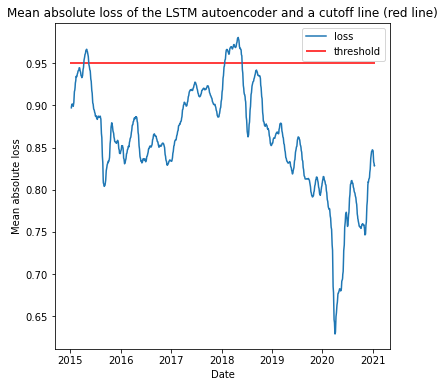

In [109]:
#Visualise
plt.figure(figsize = (6,6))
plt.plot(autoencoder_df['Loss'], label = 'loss')
plt.hlines(y=CUTOFF, xmin = '2015-01-01', xmax = '2021-01-16', color = 'red', label = 'threshold')
plt.xlabel('Date')
plt.ylabel('Mean absolute loss')
plt.title('Mean absolute loss of the LSTM autoencoder and a cutoff line (red line)')
plt.legend()

In [103]:
#Create an anomalies dataframe to plot later
anomalies = autoencoder_df[autoencoder_df.Anomaly == True]
anomalies['Date'] = anomalies.index

<ipython-input-103-66c086e63c16>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['Date'] = anomalies.index


Text(0.5, 1.0, 'KLSI Closing Price and Anomalies (Red Points)')

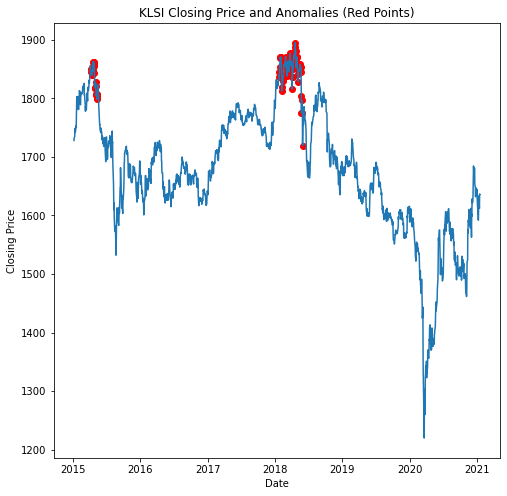

In [114]:
#Plot actual closing price of the test set and predicted anomalies
plt.figure(figsize = (8,8))
plt.plot(autoencoder_df.Close)
plt.scatter(x=anomalies.Date, y=anomalies.Close, marker = 'o', color = 'red')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('KLSI Closing Price and Anomalies (Red Points)')